In [1]:
# Useful imports
import numpy as np, matplotlib.pyplot as plt
import sys; sys.path.append('./')
import models
from data_loader import DataLoader
import emcee, corner
from sklearn.covariance import EmpiricalCovariance
import numpy.linalg as lin
import seaborn as sns

In [2]:
# Compute the harmonic mean estimator

# Set the model
E_min = 0.676 # MeV
E_max = 2.624 # MeV
which_data = 'som'
parameterization = 'bs_C'
use_theory_cov = True

param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [1.70, 3], [5.0, 25.0], [-6, 6]])
params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [1.0, 1.6], [12.59, 1.85], [0.0, 1.6]])

# # # Load in the data
loader = DataLoader(E_min, E_max, which_data)
data = loader.get_data()
norm_group = loader.get_normalization_grouping()
gauss_prior_f = loader.get_normalization_prior_info()

# # # Set the parameter bounds and initialize the model
if parameterization == 'standard':
    sys.stderr.write('No Longer Supported....')
    sys.exit(-1)
elif parameterization == 'bound_state':
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [-1, 1], [-6, 6], [-1, 1], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [0.0, 0.1], [0.0, 1.6], [0.0, 0.1], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    sys.stderr.write('Not implemented yet...')
    sys.exit(-1)
elif parameterization == 'bs_C':
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.BS_C(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)
elif parameterization == 'initial_f_wave':
    if param_bounds is None:
        param_bounds = np.array([[-0.02, 0.06], [-3, 3], [5.0, 25.0], [-6, 6], [5.0, 25.0], [-6, 6], [-3, 0]])
    if params_prior is None:
        params_prior = np.array([[0.025, 0.015], [0.8, 0.4], [13.84, 1.63], [0.0, 1.6], [12.59, 1.85], [0.0, 1.6], [-0.5, 1]]) # center, width
    gauss_prior_params = np.hstack([param_bounds, params_prior])
    model = models.F_Wave_AR(data, norm_group, gauss_prior_params, gauss_prior_f, use_theory_cov)


In [3]:
# Load the samples
lower_samples = np.load('./separate_priors/samples_low_P1_minus.npy', allow_pickle = True)
upper_samples = np.load('./separate_priors/samples_high_P1minus.npy', allow_pickle = True)

# Combine all samples (unscaled)
unscaled_samples = np.concatenate([lower_samples, upper_samples])

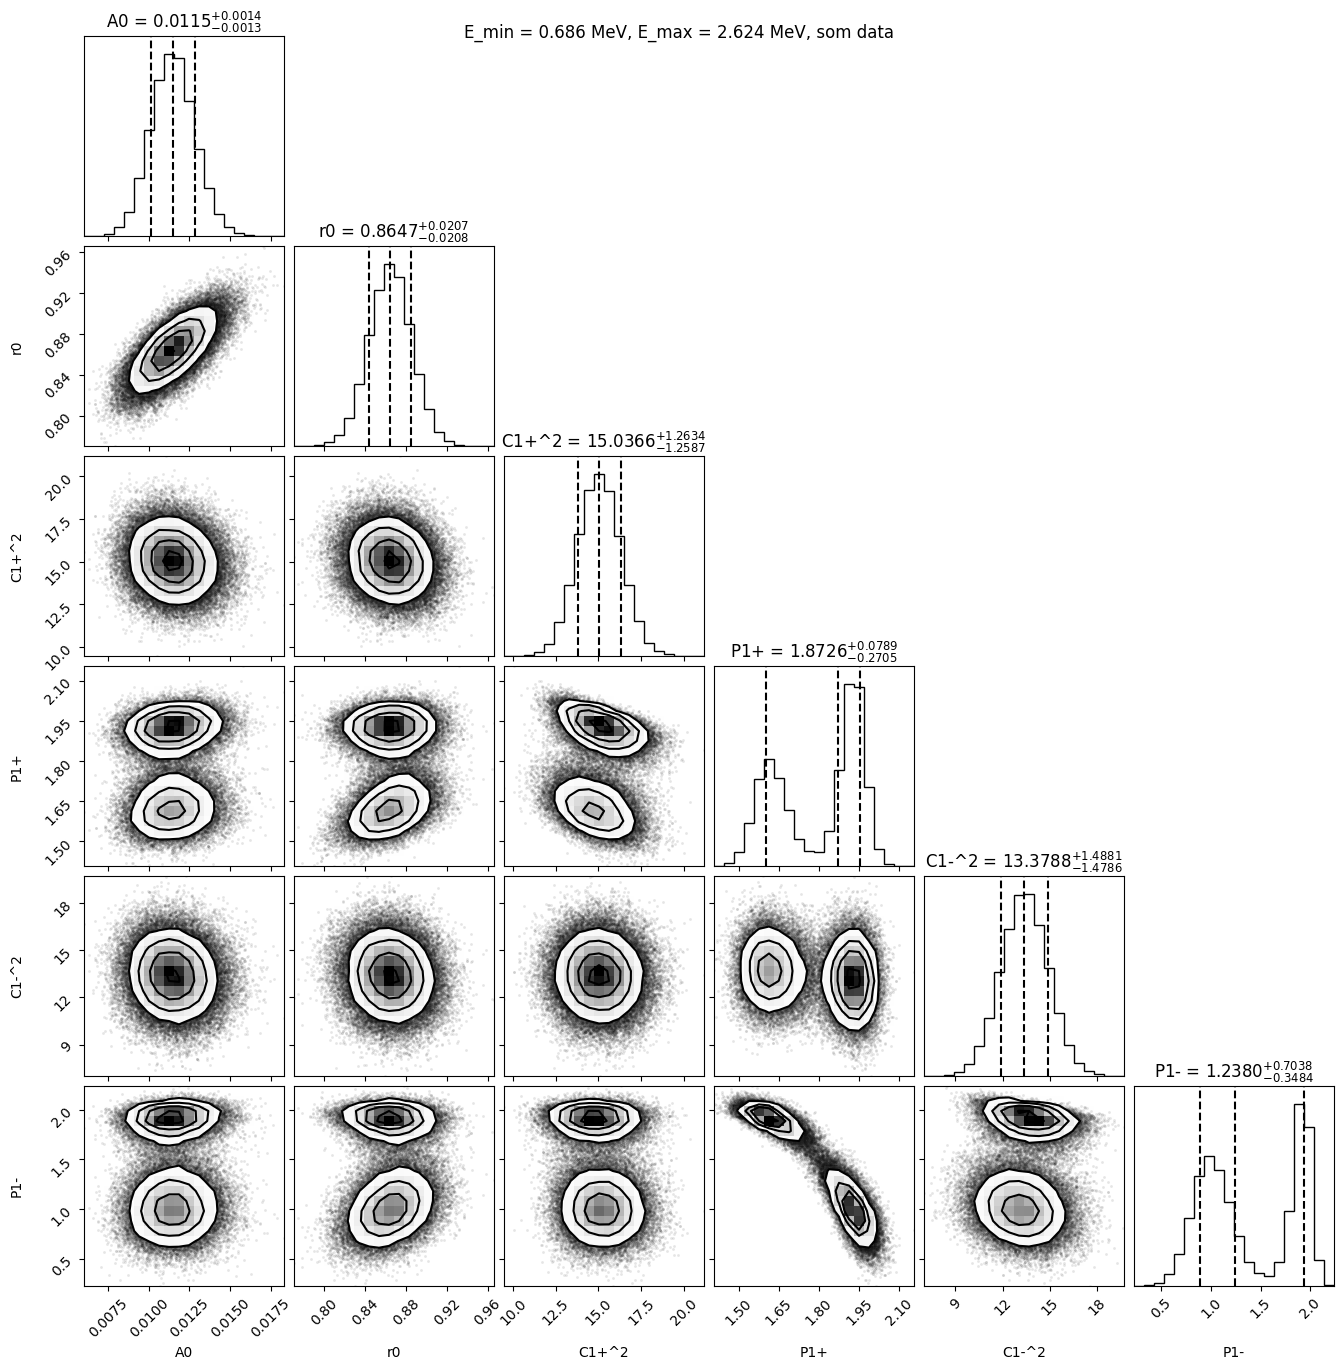

In [4]:
# Corner the unscaled samples
erp_dim = 6
E_min = 0.686
E_max = 2.624
which_data = 'som'
labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']

corner.corner(unscaled_samples[:, :erp_dim], labels = labels[:erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
plt.show()

In [5]:
# Overlap region P1- (1.45 - 1.6)
lower_overlap = lower_samples[np.where(lower_samples[:, 5] >= 1.45)[0]]
upper_overlap = upper_samples[np.where(upper_samples[:, 5] <= 1.6)[0]]

n_lower_overlap = lower_overlap.shape[0]
n_upper_overlap = upper_overlap.shape[0]

-------------
## Corner each of the overlap regions separately

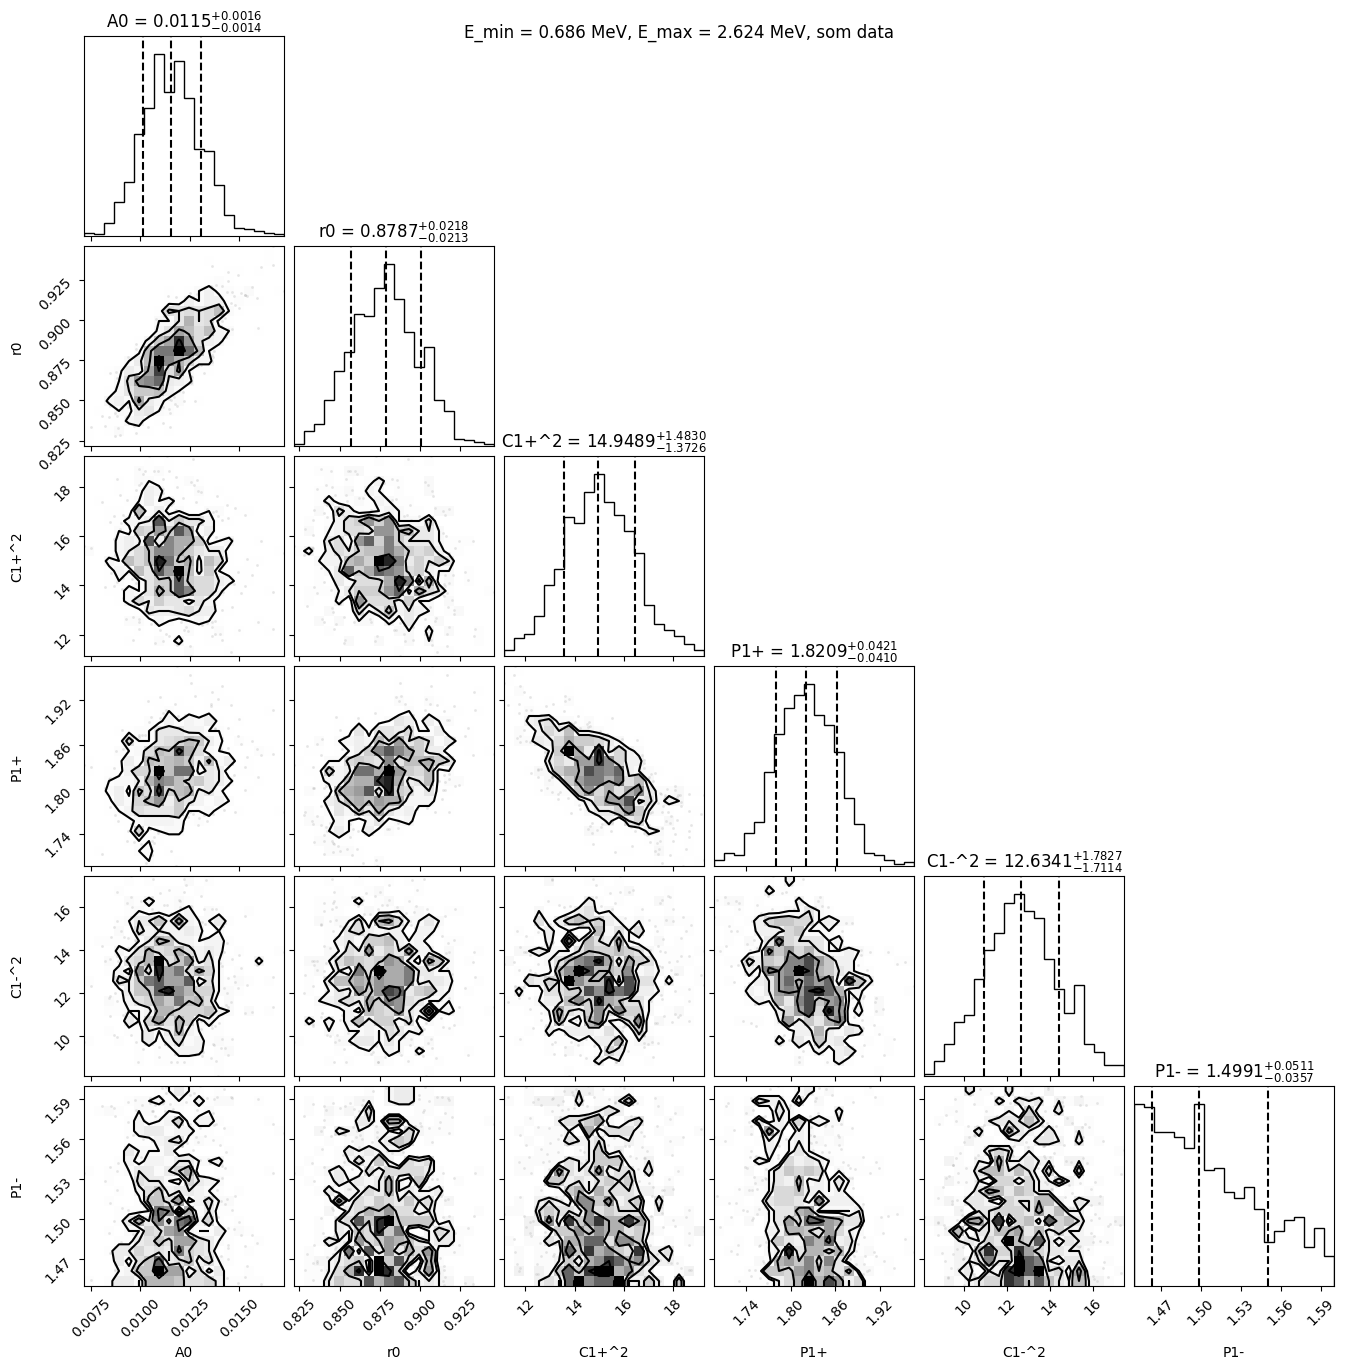

In [6]:
corner.corner(lower_overlap[:, :erp_dim], labels = labels[:erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
plt.show()

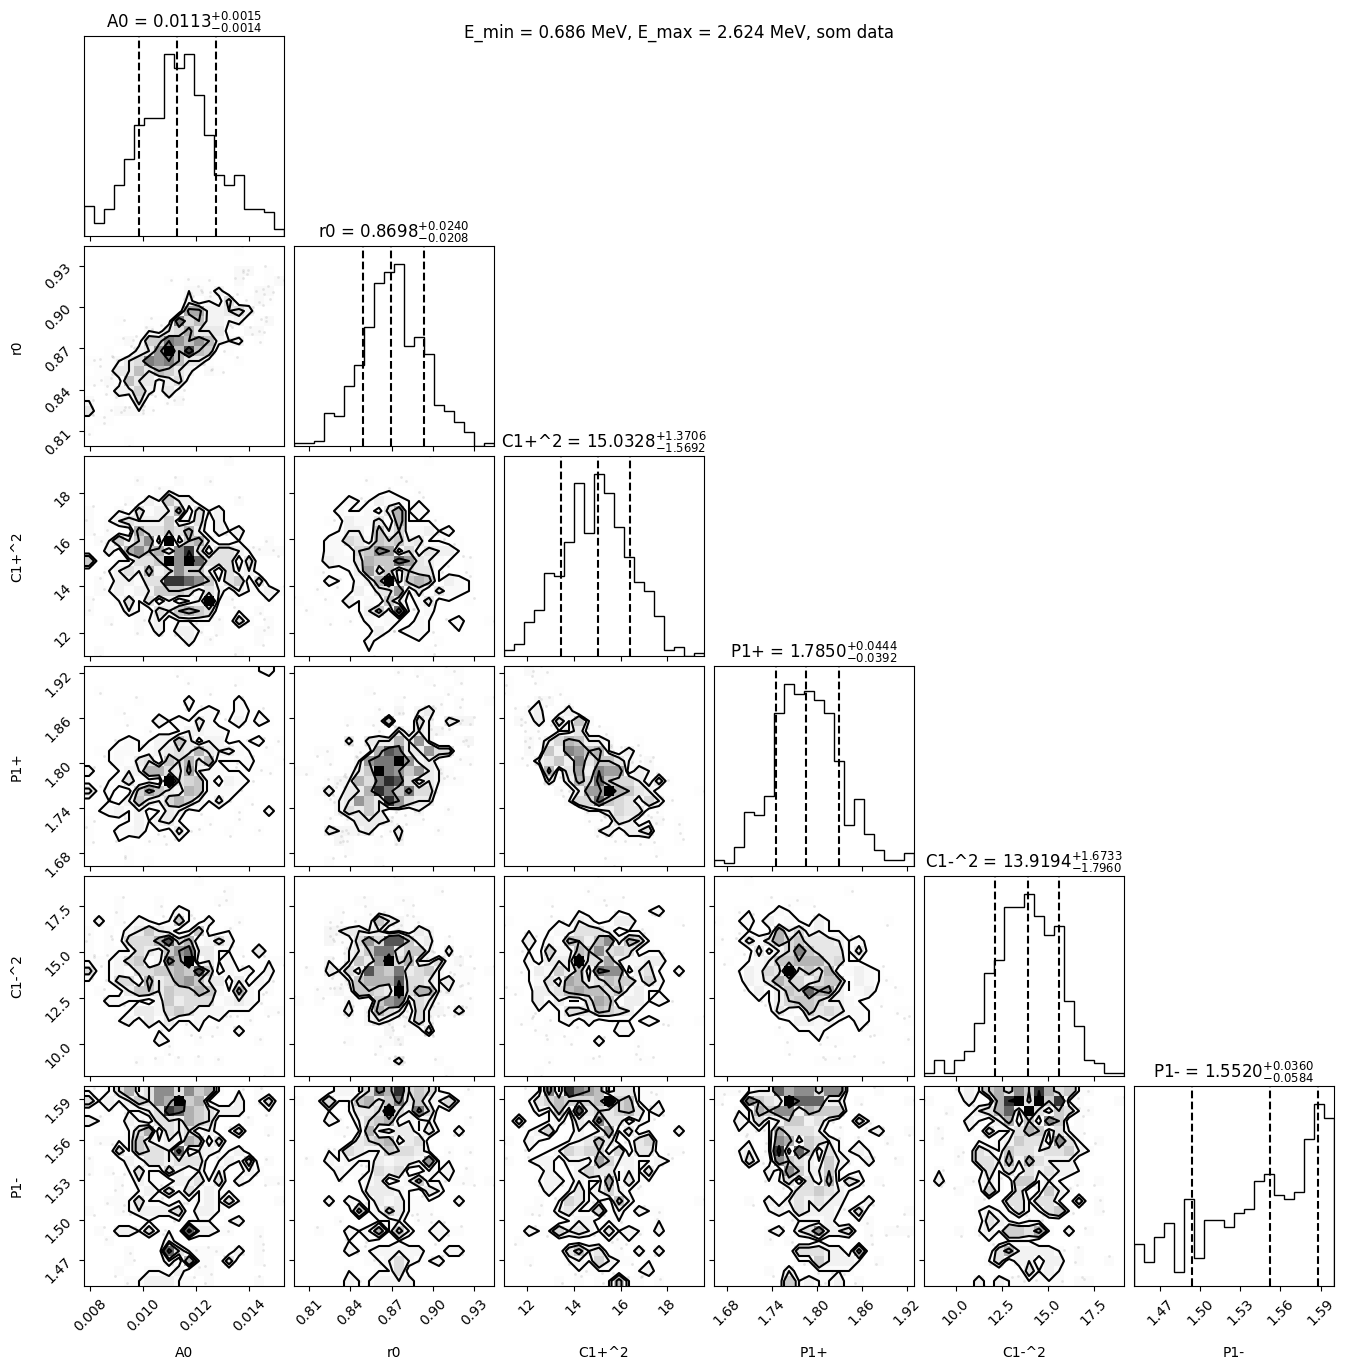

In [7]:
corner.corner(upper_overlap[:, :erp_dim], labels = labels[:erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
plt.show()

In [8]:
print('Upper: Tot - {}, Overlap - {}'.format(upper_samples.shape[0], n_upper_overlap))
print('Lower: Tot - {}, Overlap - {}'.format(lower_samples.shape[0], n_lower_overlap))

Upper: Tot - 34450, Overlap - 468
Lower: Tot - 46436, Overlap - 759


$$
    \hat{P_{1}} (D) = \left\{ \frac{1}{m} \sum_{i = 1}^{m} P(D | \vec{\theta}^{(i)})^{-1}  \right\}^{-1}
$$

In [9]:
# log_likelihood_lower = np.array([model.log_likelihood(i).real for i in lower_samples])
# likelihood_lower = np.exp(log_likelihood_lower)
# likelihood_lower = likelihood_lower[np.where(likelihood_lower != 0, likelihood_lower)[0]]
# m1_lower = likelihood_lower.shape[0]

# likelihood_upper = np.array([model.log_likelihood(i).real for i in upper_samples])
# m1_upper = likelihood_upper.shape[0]


# hme1_lower = 1 / ((1 / m1_lower) * np.sum(1 / np.exp(likelihood_lower)))
# hme1_upper = 1 / ((1 / m1_upper) * np.sum(1 / np.exp(likelihood_upper)))

KeyboardInterrupt: 

In [ ]:
# print(hme1_lower, hme1_upper)
# np.sum(np.where(np.exp(likelihood_upper) != 0, 1, 0))
# np.exp(likelihood_upper).shape[0]

In [10]:
frac_keep = (lower_samples.shape[0] * n_upper_overlap) / (upper_samples.shape[0] * n_lower_overlap)
n_keep = int(upper_samples.shape[0] * frac_keep)
keep_indices = np.floor(np.linspace(0, upper_samples.shape[0] - 1, n_keep)).astype(int)
upper_samples = upper_samples[keep_indices]

samples = np.concatenate([upper_samples, lower_samples])

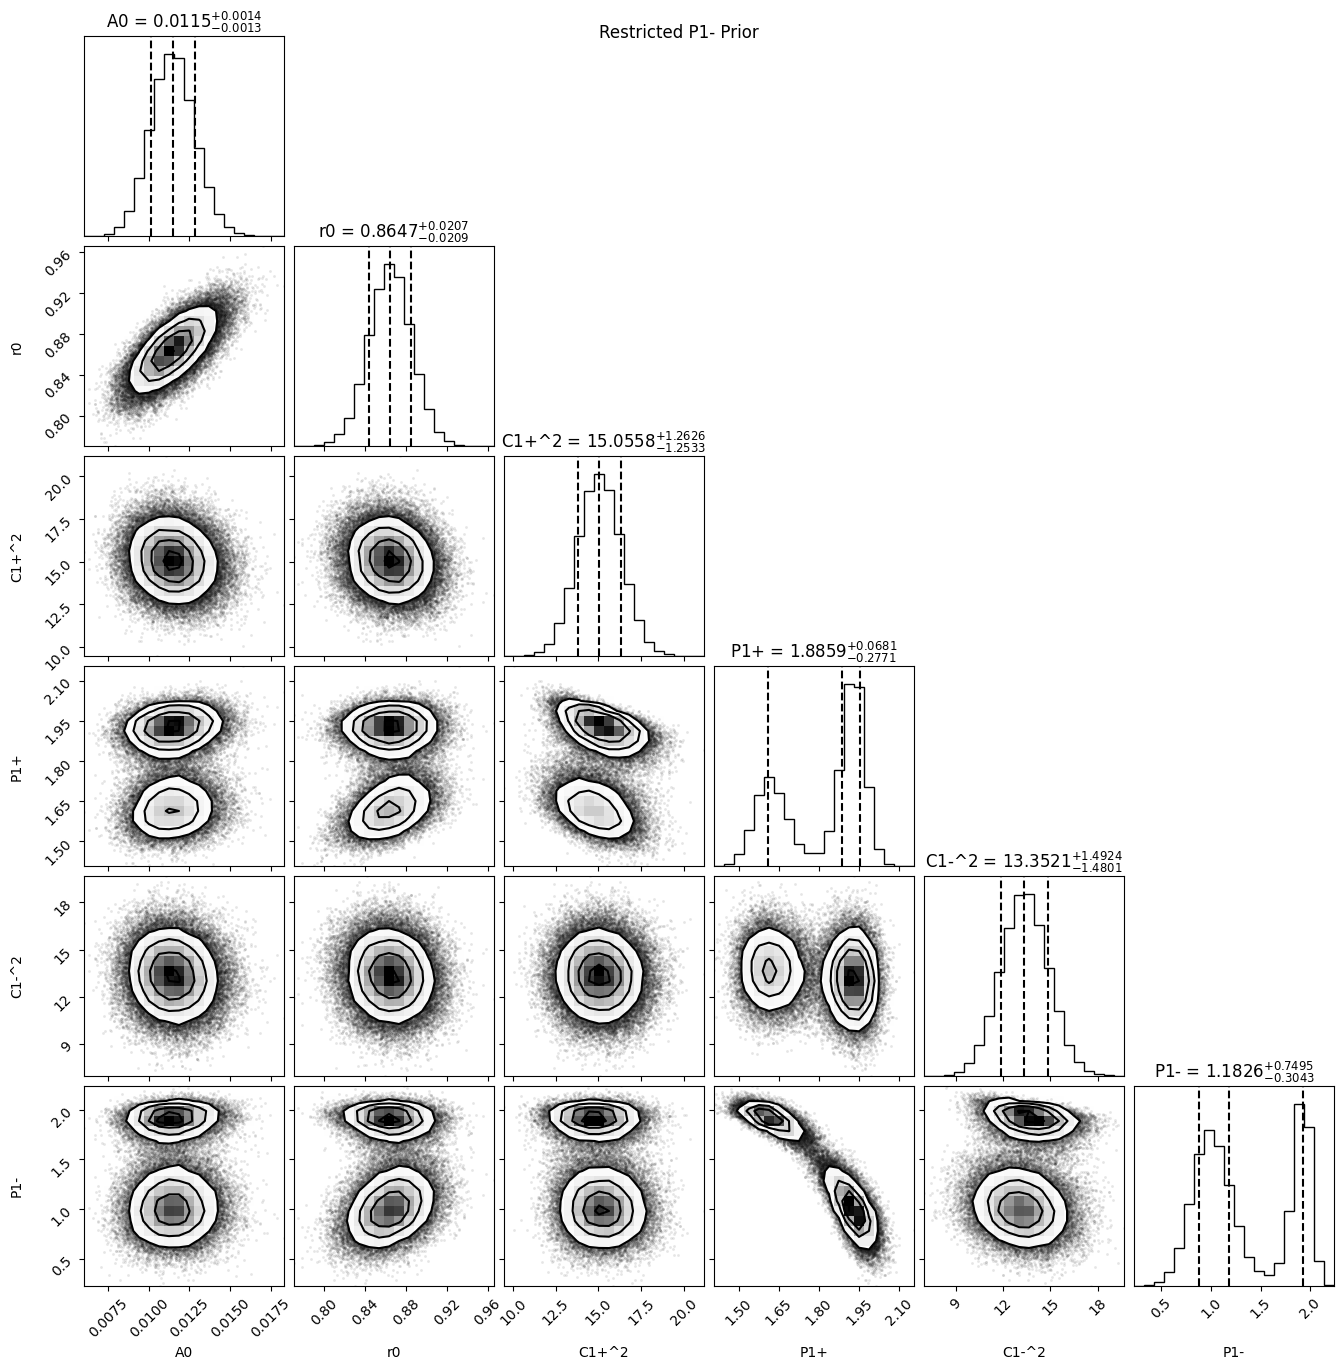

In [11]:
corner.corner(samples[:, :erp_dim], labels = labels[:erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle('Restricted P1- Prior')
plt.show()

---------------
## Now we will look at the restricted P1+ prior

In [ ]:
# Load the samples
lower_samples = np.load('./09_28_2023/run1/samples_1.npy', allow_pickle = True)
upper_samples = np.load('./09_28_2023/run0/samples_0.npy', allow_pickle = True)

# Combine all samples (unscaled)
unscaled_samples = np.concatenate([lower_samples, upper_samples])

In [ ]:
# Corner the unscaled samples
erp_dim = 6
E_min = 0.686
E_max = 2.624
which_data = 'som'
labels = ['A0', 'r0', 'C1+^2', 'P1+', 'C1-^2', 'P1-']

corner.corner(unscaled_samples[:, :erp_dim], labels = labels[:erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle("E_min = {} MeV, E_max = {} MeV, {} data".format(E_min, E_max, which_data))
plt.show()

In [ ]:
# Overlap region P1+ (1.7 - 1.8)
lower_overlap = lower_samples[np.where(lower_samples[:, 5] >= 1.7)[0]]
upper_overlap = upper_samples[np.where(upper_samples[:, 5] <= 1.8)[0]]

n_lower_overlap = lower_overlap.shape[0]
n_upper_overlap = upper_overlap.shape[0]

In [ ]:
print('Upper: Tot - {}, Overlap - {}'.format(upper_samples.shape[0], n_upper_overlap))
print('Lower: Tot - {}, Overlap - {}'.format(lower_samples.shape[0], n_lower_overlap))

In [ ]:
frac_keep = (lower_samples.shape[0] * n_upper_overlap) / (upper_samples.shape[0] * n_lower_overlap)
n_keep = int(upper_samples.shape[0] * frac_keep)
keep_indices = np.floor(np.linspace(0, upper_samples.shape[0] - 1, n_keep)).astype(int)
upper_samples = upper_samples[keep_indices]

samples = np.concatenate([upper_samples, lower_samples])

In [ ]:
corner.corner(samples[:, :erp_dim], labels = labels[:erp_dim], quantiles = [0.16, 0.5, 0.84], title_fmt = '.4f', show_titles = True)
plt.suptitle('Restricted P1+ Prior')
plt.show()

------------